# <div style="text-align: center">18.335/6.337 Problem Set 2 - SVD and Gram–Schmidt</div>
## <div style="text-align: center">Solution</div>
### <div style="text-align: center">Created by Wonseok Shin</div>

$\newcommand{\Cmat}[2]{\mathbb{C}^{#1\times#2}}\newcommand{\Cvec}[1]{\mathbb{C}^{#1}}\newcommand{\Rmat}[2]{\mathbb{R}^{#1\times#2}}\newcommand{\Rvec}[1]{\mathbb{R}^{#1}}\newcommand{\null}{\mathrm{null}}\newcommand{\range}{\mathrm{range}}\newcommand{\rank}{\mathrm{rank}}\newcommand{\nullity}{\mathrm{nullity}}\newcommand{\sign}{\mathrm{sign}}\newcommand{\norm}[1]{\left\|#1\right\|}\newcommand{\abs}[1]{\left|#1\right|}\newcommand{\epsmach}{\epsilon_\mathrm{machine}}\newcommand{\log}{\mathrm{log}}\newcommand{\tanh}{\mathrm{tanh}}\newcommand{\l}{\lambda}\newcommand{\d}{\delta}$

## Problem 1.  Low-rank approximation via SVD [2 pts]

In this problem, we will see the efficiency of the low-rank approximation of a matrix via SVD.  Specifically, we will see that the low-rank approximation of our $2000\times2000$ test matrix $A$ allows us to calculate $A x$ much faster with only small error.

### Assignment 1.1.  Choose the rank  [0.5 pt]

When the SVD of $A\in \mathbb{C}^{m\times n}$ is $A=\sum _{j=1}^p \sigma _j u_j v_j^*$, the low-rank approximation of $A$ is a partial sum $A_k = \sum _{j=1}^k \sigma _j u_j v_j^*$, where $1\le k \le p=\min\{m,n\}$.  

For an accurate-yet-efficient approximation, the correct choice of the rank $k$ is very important.  Typically, we only keep the terms with relatively large $\sigma_j$'s.  In this problem set, we will keep all the terms with $\sigma_j$'s greater than or equal to 1% of $\sigma_1$.

Implement `find_k` below that takes a vector of $\sigma_j$'s and returns $k$ such that $\sigma_k / \sigma_1\ge 0.01$ and $\sigma_{k+1}/\sigma_1<0.01$.

In [1]:
function find_k(σ)  # σ: vector of σⱼ's
    σ₁ = σ[1]
    k = findlast(σ .≥ 0.01σ₁)

    return k
end

find_k (generic function with 1 method)

### Assignment 1.2.  Apply $A_k$ to $x$ [0.5 pt]

Now, we implement the operation of $A_k$ on $x$.  Complete `apply_Aₖ` below that takes the SVD components of $A$ together with $k$ and $x$, and returns $A_k x$.

Hint: when implementing $B C x$ numerically for some matrices $B$ and $C$, it is very important to implement it as $B (C x)$ rather than $(B C) x$.  Why do you think this is the case?  (You don't have to submit the answer to this question.)

In [2]:
function apply_Aₖ(U, σ, V, k, x)
    Uₖ = @view U[:,1:k]
    σₖ = @view σ[1:k]
    Vₖ = @view V[:,1:k]

#     yₖ = Uₖ * (σₖ .* (Vₖ' * x))
    yₖ = Uₖ * (σₖ .* BLAS.gemv('C', Vₖ, x))

    return yₖ  # yₖ = Aₖ x
end

apply_Aₖ (generic function with 1 method)

### Assignment 1.3.  Measure the error in $A_k x$ [0.5 pt]

To test the accuracy of $A_k x$, complete `eval_err` below that evaluates the average error in $A_k x$ over many $x$'s.  The specific requirements are as follows.

- Pass $x$'s as the columns of a matrix $X$.
- For each $x$, calculate $A x$ and $A_k x$ (using `apply_Aₖ`), and the error $\left\|A_k x-A x\right\|_2 / \left\| A x\right\|_2$.
- Repeat the error calculation for all columns $x$ of $X$, and calculate the average error.
- Return the average error.

In [3]:
function eval_err(A, X, U, σ, V, k)
    n = size(X, 2)

    err = 0.0
    for j = 1:n
        x = @view X[:,j]

        y = A*x
        yₖ = apply_Aₖ(U, σ, V, k, x)
        err += norm(yₖ - y) / norm(y)
    end

    err /= n

    return err  # average error over columns of X
end

eval_err (generic function with 1 method)

### Assignment 1.4.  Measure the performance of $A_k x$ [0.5 pt]

To evaluate the performance of $A_k x$, complete `eval_time` below that evaluates the average time taken for calculating $A x$ and $A_k x$ over many $x$'s.  The specific requirements are as follows.

- Pass $x$'s as the columns of a matrix $X$.
- For each $x$, time the calculation of $A x$ and $A_k x$ (using `apply_Aₖ`).  Julia's `@elapsed` macro will be handy for timing.
- Repeat this time measurement for all columns $x$ of $X$, and calculate the average time taken for $A x$ and $A_k x$ separately.
- Return the average times.

In [4]:
function eval_t(A, X, U, σ, V, k)
    n = size(X, 2)

    t_A = 0.0
    t_Aₖ = 0.0
    for j = 1:n
        x = @view X[:,j]
        t_A += @elapsed A*x
        t_Aₖ += @elapsed apply_Aₖ(U, σ, V, k, x)
    end

    t_A /= n
    t_Aₖ /= n

    return t_A, t_Aₖ  # average time taken for A x, average time taken for Aₖ x
end

eval_t (generic function with 1 method)

### Verification of your implementation

Run the following code block to verify your implementation of the functions

In [5]:
# Load the test matrix and vectors, and perform SVD.
using JLD  # if not installed yet, execute Pkg.add("JLD") first

@load "A.jld"
m, n = size(A)

# Find the number of dominant singular values.
U, σ, V = svd(A)
k = find_k(σ)

# Measure the accuracy of the low-rank approximation.
N = 10  # number of x's to test
X = randn(n,N) + im*randn(n,N)  # N random complex vectors
err = eval_err(A, X, U, σ, V, k)

# Measure the performance of the low-rank approximation.
t_A, t_Aₖ = eval_t(A, X, U, σ, V, k)
t_ratio = t_A / t_Aₖ

# Print the measurement result.
println("Comparison between A x and Aₖ x")
println("------------------------------------")
println("A: m = $m, n = $n, k = $k\n")

@printf "Average error in Aₖ x = %.3f%%\n\n" 100err

@printf "time for A x: %e seconds\n" t_A
@printf "time for Aₖ x: %e seconds\n\n" t_Aₖ

@printf "Aₖ x is %.2f times faster than A x.\n" t_ratio
println("------------------------------------")

Comparison between A x and Aₖ x
------------------------------------
A: m = 2000, n = 2000, k = 5

Average error in Aₖ x = 0.330%

time for A x: 2.837683e-03 seconds
time for Aₖ x: 5.186680e-05 seconds

Aₖ x is 54.71 times faster than A x.
------------------------------------


## Problem 2.  Intersection between subspaces [4 pts]

(Inspired by Exercise 7.4 of T&B)

In this problem, we will develop a method to calculate the intersection between two subspaces $\range(A)$ and $\range(B)$ for $A \in \Cmat{m}{n}$ and $B \in \Cmat{m}{p}$.

To begin with, here are a few facts you must have learned in linear algebra class, just in case you forgot them.  Below, $X$ and $Y$ are subspaces of $\Cvec{m}$.

- $X^\bot = \{z \in \Cvec{m} \mid x^* z = 0 \text{ for all } x \in X\}$.  In other words, $X^\bot$ is the set of vectors orthogonal to all vectors in $X$.  It is called the [orthogonal complement](https://en.wikipedia.org/wiki/Orthogonal_complement) of $X$.
- $(X^\bot)^\bot = X$.
- $X + Y = \{x+y \mid x \in X, y \in Y\}$.  In other words, $X+Y$ is the set of vectors that can be decomposed into the sum of the elements of $X$ and $Y$.

**(a) [1 pt]** Show that $\range(A)^\bot = \null(A^*)$.

***Proof.***

$$
\begin{align}
\null(A^*) &=\{x \in \Cvec{m} \mid A^* x = 0\}\\
&= \{x \in \Cvec{m} \mid a_i^* x = 0 \text{ for all } i = 1, \ldots, n\}\\
&= \{x \in \Cvec{m} \mid a^* x = 0 \text{ for all } a \in \left<a_1, \ldots, a_n\right>\}\\
&= \{x \in \Cvec{m} \mid a^* x = 0 \text{ for all } a \in \range(A)\} = \range(A)^\bot.
\end{align}
$$

**(b) [1 pt]** Complete the function `null` below that takes an arbitrary matrix $A$ and returns orthonormal basis vectors of its nullspace.  (Hint: full SVD can be performed by `svd(A, thin=false)` in Julia.)

***Solution.***

From Theorem 5.2 of T&B, we know that the right singular vectors corresponding to zero singular values are orthonormal basis vectors of $\null(A)$.  This is used to implement `null` below:

In [6]:
function null(A)
    m, n = size(A)
    ~, σ, V = svd(A, thin=false)    
    r = findlast(σ .> 0)  # index of last nonzero singular value
    
    return V[:, r+1:n]
end

null (generic function with 1 method)

**(c) [1 pt]** For subspaces of $X$ and $Y$ of $\Cvec{m}$, show $(X + Y)^\bot = X^\bot \cap Y^\bot$.  (Hint: for a basis $\{a_1, \ldots, a_k\}$ of $X$, $X = \range(A)$.)

***Proof.***

For bases $\{a_1, \ldots, a_k\}$ and $\{b_1, \ldots, b_n\}$ of $X$ and $Y$, we have $X = \range(A)$ and $Y = \range(B)$.  Then, $X + Y = \left<a_1, \ldots, a_k, b_1, \ldots, b_n \right> = \range(\left[A\,\, B\right])$.  Therefore, using Part (a), we have

$$
\begin{align}
(X + Y)^\bot & = \range(\left[A\,\, B\right])^\bot\\
& = \null(\left[A\,\, B\right]^*)\\
& = \null\left(\left[
\begin{array}{c}
 A^* \\
 B^* \\
\end{array}
\right]\right)\\
& = \{x \mid A^* x = 0 \text{ and } B^*x = 0\}\\
& = \null(A^*) \cap \null(B^*)\\
& = \range(A)^\bot \cap \range(B)^\bot = X^\bot \cap Y^\bot.
\end{align}
$$

**(d) [1 pt]** Suppose $A \in \Cmat{m}{n}$ and $B \in \Cmat{m}{p}$ are full-rank and skinny.  Devise and explain a way to find an orthonormal basis of $\range(A) \cap \range(B)$ by using `null` three times.  Implement your method in the function `interspace` below that takes $A$ and $B$ and returns the orthonormal basis of $\range(A) \cap \range(B)$.  Inside `interspace`, do not perform any matrix factorization or orthogonalization outside `null`.

***Solution.***

Because $X^\bot \cap Y^\bot = (X + Y)^\bot$ from Part (c) and also $(X^\bot)^\bot = X$, we have 

$$
X \cap Y = (X^\bot)^\bot \cap (Y^\bot)^\bot = (X^\bot + Y^\bot)^\bot.
$$

Therefore,

$$
\range(A) \cap \range(B) = (\range(A)^\bot + \range(B)^\bot)^\bot = (\null(A^*) + \null(B^*))^\bot.
$$

Now, suppose that $\{c_1, \ldots, c_{m-n}\}$ and $\{c'_1, \ldots, c'_{m-p}\}$ are orthonormal bases of $\null(A^*)$ and $\null(B^*)$, respectively.  Then, for a matrix $C = \left[c_1\,\, \cdots\,\, c_{m-n}\,\, c'_1\,\, \cdots\,\, c'_{m-p}\right]$, we have $\null(A^*) + \null(B^*) = \range(C)$.  Therefore,

$$
\range(A) \cap \range(B) = \range(C)^\bot = \null(C^*).
$$




So, we can find an orthonormal basis of $\range(A) \cap \range(B)$ by taking the following steps:

- Find onthonormal bases $\{c_1, \ldots, c_{m-n}\}$ and $\{c'_1, \ldots, c'_{m-p}\}$ of $\null(A^*)$ and $\null(B^*)$ using `null` twice.
- Construct a matrix $C = \left[c_1\,\, \cdots\,\, c_{m-n}\,\, c'_1\,\, \cdots\,\, c'_{m-p}\right]$.
- Find an orthonormal basis of $\null(C^*)$ using `null` once.  Then this is an orthonormal basis of $\range(A) \cap \range(B)$.

`interspace` below implements this algorithm.

In [7]:
function interspace(A, B)
    Na = null(A')
    Nb = null(B')
    C = [Na Nb]
    
    return null(C')
end

interspace (generic function with 1 method)

### Validation of your implementation

The following script uses `interspace` to solve Exercise 7.4 of T&B.  The solution should be close to `v = [0.534673; 0.703132; 0.468754]`.  Note, however, that our `interspace` can handle more general, higher-dimensional cases.

In [8]:
a₁ = [0.9, 0.3, 0.2]
a₂ = [0.5, 0.9, 0.6]

b₁ = [0.1, 0.6, 0.1]
b₂ = [0.7, 0.4, 0.6]

A = [a₁ a₂]
B = [b₁ b₂]

v = interspace(A, B)

println("Intersection is along v = $v.")

Intersection is along v = [0.534673; 0.703132; 0.468754].


## Problem 3.  QR factorization via the Gram–Schmidt procedure [4 pts]

The functions that perform the reduced QR factorization by the Gram–Schmidt procedure, namely `clgs` and `mgs`, show up several times in numerical examples in T&B.  However, Julia does not provide these functions, because the standard method to perform the QR factorization is the Householder triangularization rather than the Gram-Schmidt procedure.  In this problem, we will write `clgs` and `mgs` so that they could be used later in the course.

`clgs` and `mgs` implement the classical and modified Gram–Schmidt procedures described in Algs. 7.1 and 8.1 of T&B.  In addition to them, we will also write an additional function, `mgsc`, which performs the modified Gram–Schmidt procedure along the *column* direction.  In terms of code, `mgsc` should look very close to `clgs`, but it must produce the numerically identical result as `mgs`.

A few general directions about writing these functions:

- For simplicity, consider only skinny or square input matrices ($A \in \mathbb{C}^{m\times n}$ with $m \ge n$).
- Handle rank-deficient $A$ properly.
- For reduced memory footprint, implement the functions such that the variable holding the input $A$ is reused to store the output matrix factor $Q$.  (In other words, overwrite the contents of the variable `A` storing the input $A$ with the computed result $Q$.)  Never allocate memory for $Q$ inside the functions.  This way of implementing algorithms is called an [in-place style](https://en.wikipedia.org/wiki/In-place_algorithm).
- Similarly, Never allocated memory for $R$ inside the functions.  Instead, create the variable for $R$ outside and pass to the functions as an input argument.  This way, we can allocated memory for $R$ only once and reuse it over several functions calls.  (See the validation code later.)

So, our functions will overwrite the contents of the input variables to store the outputs.  Julia's naming convention for functions modifying the contents of input variables is to [append `!` to function names](http://docs.julialang.org/en/stable/manual/style-guide/#append-to-names-of-functions-that-modify-their-arguments) to warn the users about the (unexpected) change of the contents of the input variables.  For example, for a vector `x`, `sort(x)` returns a separate vector containing the sorted vector, whereas `sort!(x)` overwrites `x` with the sorted result:

In [9]:
x = [2, 4, 1, 3]
y = sort(x)
println("After sort(x): x = $x")

x = [2, 4, 1, 3]
sort!(x)  # overwrite x
println("After sort!(x): x = $x")

After sort(x): x = [2, 4, 1, 3]
After sort!(x): x = [1, 2, 3, 4]


Once an algorithm is implemented in in-place style, the out-of-place version of the algorithm can be easily implemented in terms of the in-place version.  For example, the out-of-place `sort` (without trailing `!`) can be written easily by using the in-place `sort!` (with trailing `!`) as

```julia
function sort(x)
    y = copy(x)
    sort!(y)
    return y
end
```

Note that the above code keeps the contents of `x` intact.  In addition to the reduced memory footprint, the fact that the out-of-place version of an algorithm can be easily written in terms of the in-place version is another reason to prefer the in-place style.  

Following Julia's naming convention, we will name our in-place functions `clgs!`, `mgs!`, `mgsc!`.  The out-of-place counter parts, `clgs`, `mgs`, `mgsc`,  will be written in terms these in-place functions as follows:

In [10]:
# CLGS out-of-place
function clgs(A)
    m, n = size(A)
    Q = copy(A)
    R = similar(A, (n,n))
    clgs!(Q, R)    
    return (Q, R)
end

# MGS out-of-place
function mgs(A)
    m, n = size(A)
    Q = copy(A)
    R = similar(A, (n,n))
    mgs!(Q, R)
    return (Q, R)
end

# MGSC out-of-place
function mgsc(A)
    m, n = size(A)
    Q = copy(A)
    R = similar(A, (n,n))
    mgsc!(Q, R)
    return (Q, R)
end

mgsc (generic function with 1 method)

### Assignment 3.1.  CLGS, MGS, and MGSC [3 pts]

Complete `clgs!`, `mgs!`, `mgsc!` below that perform the reduced QR factorization using the classical, modified, column-wise modified Gram–Schmidt procedure, respectively.

The points for this assignment are distributed as follows:

- 0.5 pts for each function handling full-rank $A$ correctly.
- Additional 0.5 pts for each function handling rank-deficient $A$ correctly.

You are welcome to introduce your own *helper functions* to reduce the amount of code.  Whenever you recognize recurring patterns in your code, it is a good programming practice to define a helper function that handles those recurring portions.  Defining helper functions, however, is not a requirement of this problem.

***Solution.***

(See "Notes on Julia programming styles" at the end of this notebook for different coding styles available in Julia.)

I will define a helper funnction "ortho_against".  This function is used to ort

In [11]:
function ortho_against!(v, a, q)
    r = q⋅a
    v .-= r*q
    return r
end

# GS in column direction (for clgs! and mgsc!)
function gsc!(A, R, modified)
    m, n = size(A)
    assert(size(R)==(n,n))

    R .= 0  # initialize R
    for j = 1:n
        vⱼ = @view A[:,j]  # no alloc
        aⱼ = modified ? vⱼ : copy(vⱼ)  # no alloc : alloc
        
        for i = 1:j-1
            R[i,j] = ortho_against!(vⱼ, aⱼ, @view(A[:,i]))
        end
        
        R[j,j] = norm(vⱼ)
        if R[j,j] == 0
            rand!(vⱼ)
            aⱼ = modified ? vⱼ : copy(vⱼ)  # no alloc : alloc
            for i = 1:j-1
                ortho_against!(vⱼ, aⱼ, @view(A[:,i]))
            end
            normalize!(vⱼ)
        else
            vⱼ ./= R[j,j]
        end
    end
    
    return nothing
end

gsc! (generic function with 1 method)

In [12]:
# CLGS in-place
function clgs!(A, R)
    gsc!(A, R, false)
end


# MGSC in-place
function mgsc!(A, R)
    gsc!(A, R, true)
end


# MGS in-place
function mgs!(A, R)
    m, n = size(A)
    assert(size(R)==(n,n))

    R .= 0  # initialize R
    for i = 1:n
        q = @view A[:,i]  # no alloc

        R[i,i] = norm(q)
        if R[i,i] == 0
            rand!(q)
            for j = 1:i-1
                ortho_against!(q, q, @view(A[:,j]))
            end
            normalize!(q)
        else
            q ./= R[i,i]
        end

        for j = i+1:n
            v = @view A[:,j]
            R[i,j] = ortho_against!(v, v, q)
        end
    end
    
    return nothing
end

mgs! (generic function with 1 method)

### Validation of your implementation

Use the following code blocks to validate your implementation of the functions.  In the text this script prints, you should get `true` after each question mark.

In [13]:
# For full-rank A
m, n = 10, 7
A = rand(Complex128, m, n)

# Use in-place functions.
# Q and R is allocated only once outside the for loop below.
Q = similar(A)
R = similar(A, n, n)
for f_gs! = (clgs!, mgs!, mgsc!)
    Q .= A
    f_gs!(Q, R)
    println(Symbol(f_gs!), ":")
    println("QR ≈ A?  $(Q*R ≈ A)")
    println("Q'Q ≈ I?  $(Q'Q ≈ eye(n))")
    println()
end

# Use out-of-place functions.
Qm, Rm = mgs(A)
Qmc, Rmc = mgsc(A)
println("Q's identical for MGS and MGSC?  $(Qm == Qmc)")
println("R's identical for MGS and MGSC?  $(Rm == Rmc)")

clgs!:
QR ≈ A?  true
Q'Q ≈ I?  true

mgs!:
QR ≈ A?  true
Q'Q ≈ I?  true

mgsc!:
QR ≈ A?  true
Q'Q ≈ I?  true

Q's identical for MGS and MGSC?  true
R's identical for MGS and MGSC?  true


In [14]:
# For rank-deficient A
A = Float64[
    1 2 2 1 
    1 -1 1 1
    1 2 2 -1
    1 -1 1 1
]
m, n = size(A)

# Use in-place functions.
# Q and R is allocated only once outside the for loop below.
Q = similar(A)
R = similar(A, n, n)
for f_gs! = (clgs!, mgs!, mgsc!)
    Q .= A
    f_gs!(Q, R)
    println(Symbol(f_gs!), ":")
    println("QR ≈ A?  $(Q*R ≈ A)")
    println("Q'Q ≈ I?  $(Q'Q ≈ eye(n))")
    println()
end

Qm, Rm = mgs(A)
Qmc, Rmc = mgsc(A)
println("Q's NOT identical for MGS and MGSC?  $(Qm ≠ Qmc)")
println("R's NOT identical for MGS and MGSC?  $(Rm ≠ Rmc)")

clgs!:
QR ≈ A?  true
Q'Q ≈ I?  true

mgs!:
QR ≈ A?  true
Q'Q ≈ I?  true

mgsc!:
QR ≈ A?  true
Q'Q ≈ I?  true

Q's NOT identical for MGS and MGSC?  true
R's NOT identical for MGS and MGSC?  true


### Assignment 3.2.  $\hat{Q}$ of CLGS vs. $\hat{Q}$ of MGS [1 pt]

It is known that the columns of $\hat{Q}$ constructed by MGS are closer to being orthogonal than those constructed by CLGS.  In this assignment we will numerically verify if this is really the case.

The quality of orthogonality of the columns of $\hat{Q}$ can be measured by the error in $\hat{Q}^* \hat{Q}$: if it is closer to $I$, the columns of $\hat{Q}$ are closer to being orthogonal.

Complete `compare_gs` below that measures the errors in $\hat{Q}^* \hat{Q}$ of CLGS and MGS for $N$ randomly generated test matrices of size $m$-by-$n$.  Use the matrix 1-norm to measure the errors.

In [15]:
function compare_gs(N, m, n)
    I = eye(n)
    err_cl = Vector{Float64}(N)
    err_m = Vector{Float64}(N)
    
    A = Matrix{Float64}(m, n)
    Q = similar(A)
    R = similar(A, n, n)
    for i = 1:N
        rand!(A)

        Q .= A
        clgs!(Q, R)
        err_cl[i] = norm(Q'Q - I, 1)

        Q .= A
        mgs!(Q, R)
        err_m[i] = norm(Q'Q - I, 1)
    end
    
    return err_cl, err_m  # two length-N vectors containing errors in Q'Q for Q by clgs! and mgs!
end

compare_gs (generic function with 1 method)

### Validation of your implementation

Use the following code block to plot the measured errors.  You will see that the errors for MGS stay always lower than the errors for CLGS for all matrices.

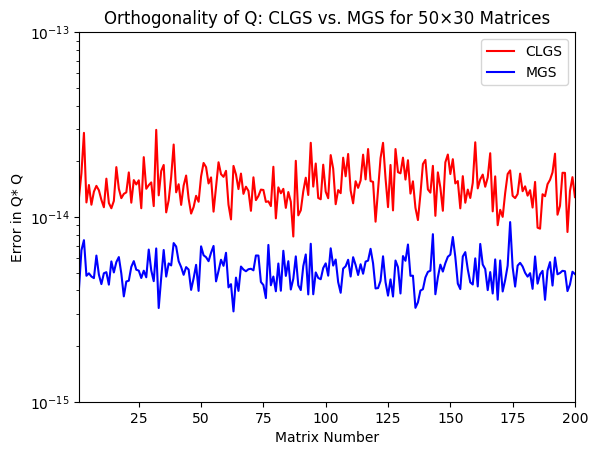

PyObject <matplotlib.legend.Legend object at 0x107733d68>

In [16]:
N = 200
m, n = 50, 30
err_cl, err_m = compare_gs(N, m, n)

using PyPlot  # if not installed yet, execute Pkg.add("PyPlot") first

semilogy(1:N, err_cl, "r-", 1:N, err_m, "b-")
axis([1,N,1e-15,1e-13])
title("Orthogonality of Q: CLGS vs. MGS for $m×$n Matrices")
xlabel("Matrix Number")
ylabel("Error in Q* Q")
legend(["CLGS", "MGS"])

## Bonus Problem.  Iterative refinement of the Gram–Schmidt procedure [2 pts]

The Gram–Schmidt procedure orthogonalizes the $j$th column $a_j$ of $A$ against the already constructed orthonormal vectors $q_1, \ldots, q_{j-1}$ as
$$
v_j = a_j - \sum_{i=1}^{j-1} r_{ij} q_i
$$
with $r_{ij} = q_i^* a_j$, and constructs a new orthonormal vector $q_j$ by normalizing $v_j$ as
$$
q_j = \frac{v_j}{r_{jj}}
$$
with $r_{jj} = \norm{v_j}_2$.  However, for rank-deficient $A$, we have $v_j = 0$ for some $j$ and the above normalization step fails with division by zero.  In fact, one of the goals of Prob. 3 was to handle rank-deficient $A$ properly by avoiding such division by zero.

However, avoiding division by zero is not sufficient in some cases.  If $A$ is *nearly* rank-deficient, $v_j$ becomes close to a zero vector for some $j$ because $a_j$ and $\sum_{i=1}^{j-1} r_{ij} q_i$ are close.  Then, due to catastrophic cancellation between $a_j$ and $\sum_{i=1}^{j-1} r_{ij} q_i$, the resulting $v_j$ becomes inaccurate and less orthogonal to $q_1, \ldots, q_{j-1}$.  Therefore, the Gram–Schmidt procedure produces $\hat{Q}$ with nonorthogonal columns for nearly rank-deficient $A$.

One way to overcome this problem is iterative refinement.  The main problem is that $v_j$ calculated above is nonorthogonal to $q_1, \ldots, q_{j-1}$.  This means $v_j$ still contains some components of $q_1, \ldots, q_{j-1}$.  Iterative refinement extracts these remaining components of $q_1, \ldots, q_{j-1}$ by orthogonalizing $v_j$ against them once more, and add these additionally extracted coefficients of $q_1, \ldots, q_{j-1}$ to the previously extracted coefficients.  By repeating this refinement, we can eventually obtain $v_j$ very orthogonal to $q_1, \ldots, q_{j-1}$.  This refinement procedure can be expressed as follows:
$$
\begin{align}
&r_{ij} = 0 \text{ for } 1 \le i \le j-1\\
&v_j^{(0)} = a_j\\
&\text{for } k = 0, 1, 2, \ldots, K-1\\
&\qquad v_j^{(k+1)} = v_j^{(k)} - \sum_{i=1}^{j-1} r_{ij}^{(k)} q_i\\
&\qquad r_{ij} \leftarrow r_{ij} + r_{ij}^{(k)}\text{ for } 1 \le i \le j-1\\
&\text{end}\\
&r_{jj} = \norm{v_j^{(K)}}_2\\
&q_j = v_j^{(K)} / r_{jj}
\end{align}
$$

This refinement can be implemented in the classical and column-wise modified Gram–Schmidt procedure.  However, it cannot be implemented in the original modified Gram–Schmidt procedure, because the refinement must be performed several times along the column direction in order to generate a new orthogonal vector $q_j$.

### Assignment B.1.  CLGS and MGSC with iterative refinement [1 pt]

Complete `clgsi!` and `mgsci!` below that implement the above-described iterative refinement in CLGS and MGSC.  

In the above algorithm, $K-1$ is the number of refinement steps.  In practice, even $K-1 = 1$ improves orthogonality of $\hat{Q}$ dramatically for nearly rank-deficient $A$.  However, in order to achieve the ultimate result, perform refinement until $v_j^{(k+1)}$ becomes numerically orthogonal to $q_1, \ldots, q_{j-1}$, i.e., until $\abs{q_i^* v_j^{(k+1)}} < \epsmach \norm{v_j^{(k+1)}}_2$.  At the same time, to prevent the refinement from running too long, limit the maximum number of refinement steps to $K = 10$.

In [17]:
# CLGS with iterative refinement, out-of-place
function clgsi(A)
    m, n = size(A)
    Q = copy(A)
    R = similar(A, (n,n))
    clgsi!(Q, R)    
    return (Q, R)
end

# MGSC with iterative refinement, out-of-place
function mgsci(A)
    m, n = size(A)
    Q = copy(A)
    R = similar(A, (n,n))
    mgsci!(Q, R)
    return (Q, R)
end

mgsci (generic function with 1 method)

In [18]:
function gsci!(A, R, modified)
    m, n = size(A)
    assert(size(R)==(n,n))
    
    ε_mach = 0.5eps()
    max_iter = 10

    R .= 0  # initialize R
    for j = 1:n
        vⱼ = @view A[:,j]  # no alloc
        Q = @view A[:,1:j-1]
        num_iter = 0
        while norm(Q'vⱼ, Inf) > ε_mach * norm(vⱼ) && num_iter < max_iter
            aⱼ = modified ? vⱼ : copy(vⱼ)  # no alloc : alloc
            for i = 1:j-1
                R[i,j] += ortho_against!(vⱼ, aⱼ, @view(A[:,i]))
            end
            num_iter += 1
        end
        
        R[j,j] = norm(vⱼ)
        if R[j,j] == 0
            rand!(vⱼ)
            num_iter = 0
            while norm(Q'vⱼ, Inf) > ε_mach * norm(vⱼ) && num_iter < max_iter
                aⱼ = modified ? vⱼ : copy(vⱼ)  # no alloc : alloc
                for i = 1:j-1
                    ortho_against!(vⱼ, aⱼ, @view(A[:,i]))
                end
                num_iter += 1
            end
            normalize!(vⱼ)
        else
            vⱼ ./= R[j,j]
        end
    end
    
    return nothing
end

gsci! (generic function with 1 method)

In [19]:
# CLGSI with iterative refinement, in-place
function clgsi!(A, R)
    gsci!(A, R, false)
end


# MGSCI with iterative refinement, in-place
function mgsci!(A, R)
    gsci!(A, R, true)
end

mgsci! (generic function with 1 method)

### Validation of your implementation

The following code block shows that `clgs!` and `mgsc!` fail to generate $\hat{Q}$ with orthogonal columns for a nearly rank-deficient matrix $A$, whereas `clgsi!` and `mgsci!` succeed.

In [20]:
# For nearly rank-deficient A
m, n = 10, 6
A = zeros(Complex128, m, n)
rand!(@view A[:, [1,2,6]])
for j = 3:5
    A[:,j] .+= rand() .* (@view A[:,1])
    A[:,j] .+= rand() .* (@view A[:,2])
end

# Use in-place functions.
# Q and R is allocated only once outside the for loop below.
Q = similar(A)
R = similar(A, n, n)
for f_gs! = (clgs!, clgsi!, mgsc!, mgsci!)
    Q .= A
    f_gs!(Q, R)
    println(Symbol(f_gs!), ":")
    println("QR ≈ A?  $(Q*R ≈ A)")
    println("Q'Q ≈ I?  $(Q'Q ≈ eye(n))")
    println()
end

clgs!:
QR ≈ A?  true
Q'Q ≈ I?  false

clgsi!:
QR ≈ A?  true
Q'Q ≈ I?  true

mgsc!:
QR ≈ A?  true
Q'Q ≈ I?  false

mgsci!:
QR ≈ A?  true
Q'Q ≈ I?  true



### Assignment B.2.  $\hat{Q}$ of CLGS vs. $\hat{Q}$ of MGSC with iterative refinement [1 pt]

In Prob. 3 we wrote `compare_gs` to demonstrate that MGS generates better $\hat{Q}$ than CLGS.  Is this still going to be true after applying iterative refinement?  

To answer this question, complete `compare_gsi` below that measures the errors in $\hat{Q}^* \hat{Q}$ of CLGS and MGSC with iterative refinement for $N$ randomly generated test matrices of size $m$-by-$n$.  Use the matrix 1-norm to measure the errors.

In [21]:
function compare_gsi(N, m, n)
    I = eye(n)
    err_cl = Vector{Float64}(N)
    err_m = Vector{Float64}(N)
    
    A = Matrix{Float64}(m, n)
    Q = similar(A)
    R = similar(A, n, n)
    for i = 1:N
        rand!(A)

        Q .= A
        clgsi!(Q, R)
        err_cl[i] = norm(Q'Q - I, 1)

        Q .= A
        mgsci!(Q, R)
        err_m[i] = norm(Q'Q - I, 1)
    end
    
    return err_cl, err_m  # two length-N vectors containing errors in Q'Q for Q by clgsi! and mgsci!
end

compare_gsi (generic function with 1 method)

### Validation of your implementation

Use the following code block to plot the measured errors.

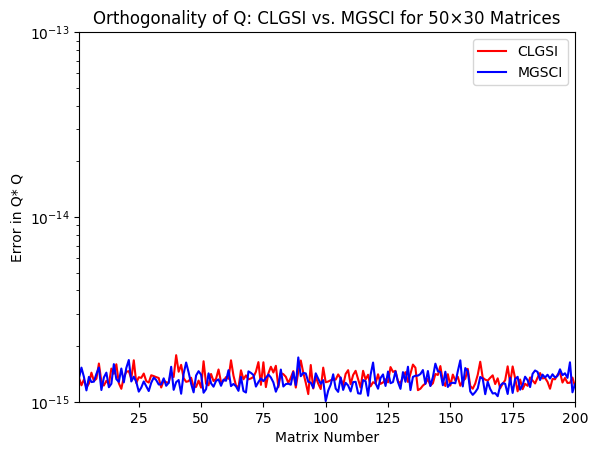

PyObject <matplotlib.legend.Legend object at 0x144a56cf8>

In [22]:
N = 200
m, n = 50, 30
err_cl, err_m = compare_gsi(N, m, n)

using PyPlot  # if not installed yet, execute Pkg.add("PyPlot") first

semilogy(1:N, err_cl, "r-", 1:N, err_m, "b-")
axis([1,N,1e-15,1e-13])
title("Orthogonality of Q: CLGSI vs. MGSCI for $m×$n Matrices")
xlabel("Matrix Number")
ylabel("Error in Q* Q")
legend(["CLGSI", "MGSCI"])

## Notes on Julia programming styles

Because Prob. 3 of this problem set is the first time we are implementing a serious algorithm in this course, I would like note different degrees of memory allocation achievable in Julia programming and their impact on the performance of code.  In this illustration, I will implement CLGS in three different ways.  For simplicity, I will consider only full-rank $A$.

The first version of `clgs!` is in MATLAB style:

In [23]:
# CLGS Version 1: MATLAB style
function clgs1!(A, R)
    m, n = size(A)
    for j = 1:n
        vⱼ = A[:,j]
        for i = 1:j-1
            R[i,j] = A[:,i]' * A[:,j]
            vⱼ = vⱼ - R[i,j] * A[:,i]
        end
        R[j,j] = norm(vⱼ)
        A[:,j] = vⱼ / R[j,j]
    end
end

clgs1! (generic function with 1 method)

Even though the code is compact, it performs too many unnecessary memory allocations.  For example, whenever something like `A[:,j]` is evaluated in the code, a vector object is created.  This way of creating a vector requires dynamic memory allocation in the heap, which turns out to be computationally costly when carried out too often.

Julia provides several tools to avoid such memory allocations.  The following second version of `clgs!` is written in Julia style by incorporating these tools as much as possible:

In [24]:
# CLGS Version 2: Julia style
function clgs2!(A, R)
    m, n = size(A)
    for j = 1:n
        aⱼ = A[:,j]  # contents copy (memory allocated for aⱼ)
        vⱼ = @view A[:,j]  # reference copy (memory not allocated for vⱼ)
        for i = 1:j-1
            qᵢ = @view A[:,i]
            R[i,j] = qᵢ⋅aⱼ
            vⱼ .-= R[i,j].*qᵢ
        end
        R[j,j] = norm(vⱼ)
        vⱼ ./= R[j,j]  # this updates contents of A
    end
end

clgs2! (generic function with 1 method)

Mainly two tools are utilized here.  First is `@view`.  When we wish to take the $j$th column of a matrix `A`, `aⱼ = @view A[:,j]` generates a "view" of the column instead of creating a column vector in a separate memory block.  The side effect of this techinque is that changing the contents of `aⱼ` also changes the contents of `A`, because `aⱼ` references a portion of the memory block of `A`.  Note that taking a scalar like `R[i,j]` does not require `@view`, because individual scalars are loaded in the statically allocated memory space called the "stack".

Second is the "dot" syntax.  You can find the detailed information about the syntax [here](https://julialang.org/blog/2017/01/moredots), but the key advantage in terms of memory allocation is that the dot syntax avoids the creation of intermediate variables.  For example, `vⱼ .-= R[i,j].*q` updates `vⱼ` element-by-element, so no additional vector variables need to be created.  However, if you did `vⱼ -= R[i,j]*qᵢ`, then it would create a vector to store `R[i,j]*qᵢ` first, another vector to store `vⱼ - R[i,j]*qᵢ`, and then would finally replace the contents of `vⱼ` with the result.  Note that two intermediate vectors would need to be created in the latter scenario.

Even using these tricks does not completely eliminate unnecessary memory allocations.  For example, `@view A[:,j]` requires some memory allocations, though less than `A[:,j]`.  The unnecessary allocations can be completely eliminated by using for loops.  In MATLAB, for loops must be avoided at all cost because they are extremely slow, but in Julia they do not deteriorate performance.  

The third version of `clgs!` uses for loops to eliminate all the unnecessary memory allocations. (However, the use of for loops makes the code a bit convoluted.)

In [25]:
# CLGS Version 3: with for loops
function clgs3!(A, R)
    m, n = size(A)
    aⱼ = A[:,1]  # preallocate memory to store aⱼ
    for j = 1:n
        for k = 1:m; 
            aⱼ[k] = A[k,j]
        end
        
        for i = 1:j-1
            for k = 1:m
                R[i,j] += conj(A[k,i]) * aⱼ[k]
            end

            for k = 1:m
                A[k,j] -= R[i,j] * A[k,i]
            end
        end
        
        for k = 1:m
            R[j,j] += abs2(A[k,j])
        end
        R[j,j] = √R[j,j]
        
        for k = 1:m
            A[k,j] /= R[j,j]  # this updates contents of A
        end
    end
end


clgs3! (generic function with 1 method)

Now, let's compare the performance of the three versions of `clgs`.  We will use the [BenchmarkTools](https://github.com/JuliaCI/BenchmarkTools.jl) package:

In [26]:
using BenchmarkTools  # if not installed yet, execute Pkg.add("BenchmarkTools") first

The `@btime` macro of `BenchmarkTools` meaures computation time and memory allocation accurately.  Below, we will use the macro to compare the performance of the three different versions of `clgs` (this can take a while, so be patient):

In [27]:
m, n = 10, 10
A = rand(Complex128, m, n);

Q₁ = copy(A)
R₁ = zeros(Complex128, n, n)
@btime clgs1!($Q₁, $R₁)

Q₂ = copy(A)
R₂ = zeros(Complex128, n, n)
@btime clgs2!($Q₂, $R₂)

Q₃ = copy(A)
R₃ = zeros(Complex128, n, n)
@btime clgs3!($Q₃, $R₃)

  77.821 μs (445 allocations: 61.25 KiB)
  71.349 μs (120 allocations: 6.48 KiB)
  5.636 μs (2 allocations: 256 bytes)


As you can see, the version with for loops uses nearly no memory allocations and performs significantly faster than the other two versions.  The version written in Julia style also uses much less memory allocations and performs slightly faster than the one written in MATLAB style.

Different styles have different pros and cons, so in which style to code is up to you.  In this course the problem set solutions will be prepared mostly in Julia style, because it is well-balanced between readability and performance.